# Time Series Forecasting with Dart TCN model

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional
from darts import models, backtesting, metrics
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
%matplotlib inline

In [5]:
pd.plotting.register_matplotlib_converters()

# Dart

In [6]:
df = pd.read_csv("meli_data.csv")
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
df.head()

,date,campaign,campaign_id,target_roas,cost,impressions,clicks,ctr,conversions,conversion_value,...,impressions_slope_14_21,clicks_slope_14_21,ctr_slope_14_21,conversions_slope_14_21,conversion_value_slope_14_21,gmv_matt_slope_14_21,gmv_shapley_slope_14_21,gmv_stimulus_slope_14_21,cost_slope_14_21,site
0,2020-01-01,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,3714.71,6115306.0,119391.0,1.95,1264.49,275264.54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
1,2020-01-02,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,6481.04,10483061.0,211379.0,2.02,2920.71,667247.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
2,2020-01-03,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,5858.64,10210427.0,197818.0,1.94,2495.05,543083.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
3,2020-01-04,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,6031.34,9646553.0,189609.0,1.97,2325.83,447982.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb
4,2020-01-05,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,35000.0,6204.97,9702296.0,193787.0,2.00,2437.50,450986.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mlb


In [7]:
df_test = df[df.campaign_id == 6542458279]
df_test.tail()

,date,campaign,campaign_id,target_roas,cost,impressions,clicks,ctr,conversions,conversion_value,...,impressions_slope_14_21,clicks_slope_14_21,ctr_slope_14_21,conversions_slope_14_21,conversion_value_slope_14_21,gmv_matt_slope_14_21,gmv_shapley_slope_14_21,gmv_stimulus_slope_14_21,cost_slope_14_21,site
196,2020-07-15,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,18280.65,23059358.0,426707.0,1.85,6242.25,1371954.80,...,-0.138738,-0.121016,0.016667,-0.208915,-0.278320,-0.067455,0.014692,-0.104663,-0.222408,mlb
197,2020-07-16,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,18862.55,22955383.0,433834.0,1.89,5991.68,1385781.40,...,-0.130029,-0.131087,0.000000,-0.160822,-0.188199,-0.048722,0.056533,-0.077734,-0.205695,mlb
198,2020-07-17,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,16193.08,20987981.0,383724.0,1.83,4410.90,1040084.34,...,-0.088774,-0.087874,0.000000,-0.021866,-0.017460,0.055597,0.129896,0.021211,-0.128163,mlb
199,2020-07-18,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,15227.17,18950665.0,362079.0,1.91,3179.97,755421.18,...,-0.054994,-0.070924,-0.016216,0.060805,0.043193,0.063197,0.093467,0.059479,0.017316,mlb
200,2020-07-19,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,16256.97,20507649.0,394241.0,1.92,3820.65,815943.88,...,0.052052,0.033919,-0.015957,0.188142,0.143703,0.093155,0.130993,0.098577,0.187797,mlb


In [8]:
features = ['conversions_slope_7_21', 'gmv_stimulus_7_days_ago', 'orders_shapley_7_days_ago', 'orders_stimulus_7_days_ago', 'clicks_slope_7_21', 'gmv_shapley_slope_7_21', 'gmv_matt_slope_7_21', 'orders_matt_7_days_ago', 'search_click_share_7_days_ago', 'gmv_matt_7_days_ago', 'target_roas']

In [9]:
df_test.tail()

,date,campaign,campaign_id,target_roas,cost,impressions,clicks,ctr,conversions,conversion_value,...,impressions_slope_14_21,clicks_slope_14_21,ctr_slope_14_21,conversions_slope_14_21,conversion_value_slope_14_21,gmv_matt_slope_14_21,gmv_shapley_slope_14_21,gmv_stimulus_slope_14_21,cost_slope_14_21,site
196,2020-07-15,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,18280.65,23059358.0,426707.0,1.85,6242.25,1371954.80,...,-0.138738,-0.121016,0.016667,-0.208915,-0.278320,-0.067455,0.014692,-0.104663,-0.222408,mlb
197,2020-07-16,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,18862.55,22955383.0,433834.0,1.89,5991.68,1385781.40,...,-0.130029,-0.131087,0.000000,-0.160822,-0.188199,-0.048722,0.056533,-0.077734,-0.205695,mlb
198,2020-07-17,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,16193.08,20987981.0,383724.0,1.83,4410.90,1040084.34,...,-0.088774,-0.087874,0.000000,-0.021866,-0.017460,0.055597,0.129896,0.021211,-0.128163,mlb
199,2020-07-18,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,15227.17,18950665.0,362079.0,1.91,3179.97,755421.18,...,-0.054994,-0.070924,-0.016216,0.060805,0.043193,0.063197,0.093467,0.059479,0.017316,mlb
200,2020-07-19,MLB_ML_G_AO_MLB263532-Ferramentas e Construcao...,6542458279,16821.0,16256.97,20507649.0,394241.0,1.92,3820.65,815943.88,...,0.052052,0.033919,-0.015957,0.188142,0.143703,0.093155,0.130993,0.098577,0.187797,mlb


## Create multivariate TimeSeries
Add missing dates and values if missing and remove data with 0 value

In [10]:
date_division = "20200625"
df_test  =df_test[df_test.net_revenue != 0]
series = TimeSeries.from_dataframe(df_test, "date", ["net_revenue", *features] )
series = missing_values.auto_fillna(series, method="slinear")
train, val = series.split_after(pd.Timestamp(date_division))
len(series), len(df_test)

(186, 186)

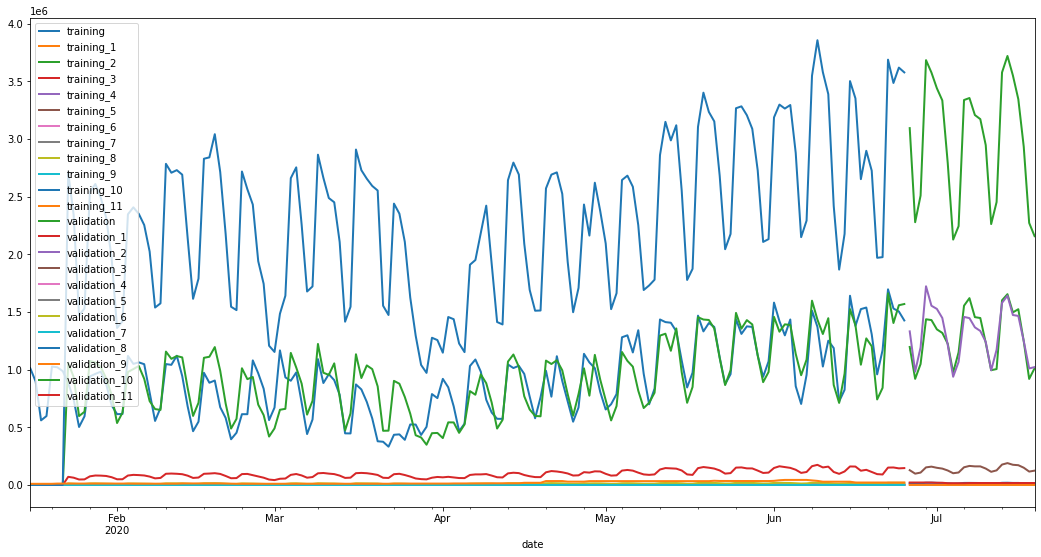

In [11]:
train.plot(lw=2, label='training', figsize=(18,9))
val.plot(lw=2, label='validation', figsize=(18,9))
plt.legend();

## RNN multivariate

In [12]:
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
ts_transformed = transformer.transform(series)
ts_transformed.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,0.465520,0.215514,0.568311,0.570149,0.592908,0.206457,0.324597,0.326299,0.630702,0.455847,0.598121,0.296418
std,0.243660,0.136306,0.221803,0.222918,0.220797,0.118098,0.153897,0.134622,0.213161,0.184964,0.212735,0.297758
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.270338,0.129535,0.420525,0.419928,0.456701,0.143789,0.272873,0.273600,0.507218,0.348151,0.446924,0.064897
50%,0.462388,0.188455,0.588923,0.555359,0.594832,0.183543,0.312398,0.311616,0.643768,0.417254,0.619821,0.162006
75%,0.631852,0.265895,0.704295,0.720221,0.728606,0.249298,0.386648,0.377286,0.762529,0.544894,0.735765,0.657087
max,1.000000,1.000000,1.036965,1.086675,1.070192,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
my_model = models.RNNModel(
    model="GRU",
    n_epochs=1000, 
    input_size=12,
    output_length=5,
    n_rnn_layers=3,
    dropout=0.1
)

In [23]:
my_model.fit(train_transformed, val_series=val_transformed, target_indices=[0],
 verbose=False)

In [24]:
prediction = my_model.predict(n=5, use_full_output_length = True)

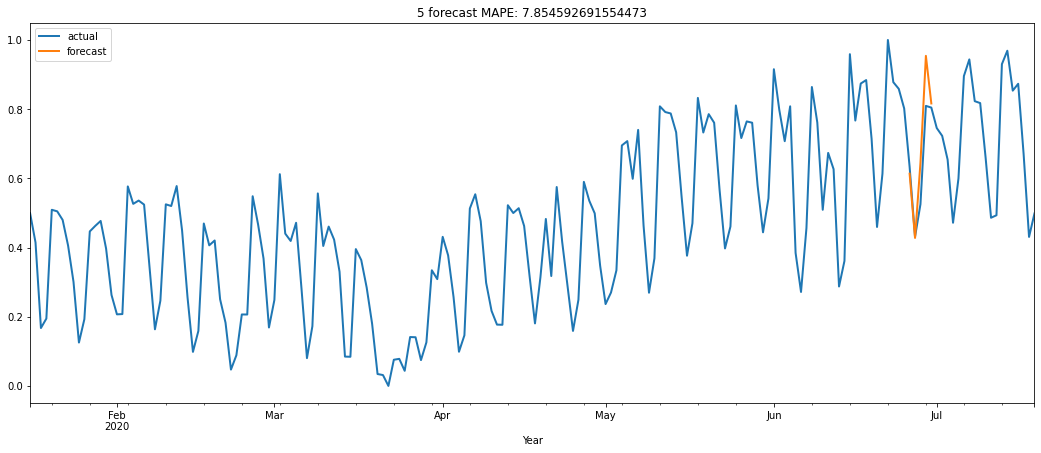

In [25]:
ts_transformed.univariate_component(0).plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")
plt.title('5 forecast MAPE: {}'.format(metrics.mape(prediction.slice_intersect(val_transformed), val_transformed.univariate_component(0))))
plt.legend();